# **1. Importing the libraries**

In [ ]:
"""
This code has been developed by Amir. H Haddadi (MS student at Sharif UT)
*LinkedIn:
*E-Mail:

A brief review on using this code is available on (https://medium.com/@amir6haddadi)

Citation:
MATLAB source code of the modified version of the HBV hydrologic model model including automatic parameter uncertainty estimation based on the Generalized likelihood uncertainty estimation (GLUE).
Nakhjiri N., Habib E., and AghaKouchak A.

AghaKouchak A., Habib E., 2010, Application of a Conceptual Hydrologic
Model in Teaching Hydrologic Processes, International Journal of Engineering Education, 26(4), 963-973.

AghaKouchak A., Nakhjiri N., and Habib E., 2012, An educational model for ensemble streamflow
simulation and uncertainty analysis, Hydrology and Earth System Sciences Discussions, 9, 7297-7315, doi:10.5194/hessd-9-7297-2012.

Dr. Khorashadizadeh's lectures (Uncertainty analysis in hydrological models)- Sharif University of Technology|(https://sharif.edu/~khorashadi/index.html)
"""



import numpy as np
import pandas as pd
from scipy.stats import qmc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
excel_data = pd.read_excel("HBVinputs.xlsx", sheet_name=None)

# **2. Extracting the essential data from the input excel file**

In [ ]:
input_data = excel_data["InputPrecipTemp"]
q_obs_data = excel_data["Qobs"]
evap_data = excel_data["MonthlyTempEvap"]
bounds_data = excel_data["Bounds"]
iv_data = excel_data["IV"].set_index("name")["val"]

# Inputs
prec = input_data["Precipitation"].values
temp = input_data["Temperature"].values
month = input_data["Month"].values.astype(int) - 1
q_obs = q_obs_data["Qobs"].values

# Monthly evapotranspiration
dpem = evap_data["dpem"].values

# Initial values and config
tt = iv_data["T_t"]
area = iv_data["WatershedArea"]
ns = 100
#ns = int(iv_data["NumberOfSimulation"])
init_snow = iv_data["SnowMeltThr"]
init_soil = iv_data["SoilMoisture"]
init_s1 = iv_data["S_1"]
init_s2 = iv_data["S_2"]
opt_criterion = int(iv_data.get("OptimizationCriteria", 2))

# Bounds
lower = bounds_data["lb"].values
upper = bounds_data["ub"].values
param_names = bounds_data["name"].values

# **3.1. Latin Hypercube Sampling**

In [ ]:
sampler = qmc.LatinHypercube(d=len(lower))
sample = sampler.random(n=ns)
params_sampled = qmc.scale(sample, lower, upper)

# **3.2. Random Uniform Sampling**

In [ ]:
params_sampled = np.random.uniform(low=lower, high=upper, size=(ns, len(lower)))

# **3.3. Grid Sampling**

In [ ]:
from itertools import product

n_grid = 5
grids = [np.linspace(lb, ub, n_grid) for lb, ub in zip(lower, upper)]
grid_points = list(product(*grids))

params_sampled = np.array(grid_points[:ns])  #Cut it whenever it increases

# **3.4. Normal Distribution Sampling**

In [ ]:
mean_vals = (lower + upper) / 2
std_devs = (upper - lower) / 6  # with a %99 confidence level

params_sampled = np.random.normal(loc=mean_vals, scale=std_devs, size=(ns, len(lower)))

params_sampled = np.clip(params_sampled, lower, upper)

# **4. Start HBV Simulating (Fast and Slow Reservoirs)**

In [ ]:
# You can ignor this parameter or set a value for it
cflux_coeff = 0.00001
smooth_window = 1

simulation_results = []

n = len(temp)
aq = np.mean(q_obs)
mqo = np.sum(q_obs)

best_idx = None
best_score = -np.inf
qms_all = []


for s in range(ns):
    d, fc, beta, c, k0, l, k1, k2, kp, pwp = params_sampled[s]
    snow = init_snow
    soil = init_soil
    s1 = init_s1
    s2 = init_s2
    qsim = []

    for i in range(n):
        T = temp[i]
        P = prec[i]
        ep = (1 + c * (T - dpem[month[i]])) * dpem[month[i]]

        if T < tt:
            snow += P
            lwater = 0
        else:
            melt = d * (T - tt)
            melt = min(melt, snow)
            snow = max(snow - melt, 0)
            lwater = P + melt

        ea = ep if soil > pwp else ep * (soil / pwp)
        dq = lwater * (soil / fc) ** beta if soil > 0 else 0
        soil += lwater - dq - ea

        # Capillary Flux
        soil_deficit = max(fc - soil, 0)
        cflux = min(cflux_coeff * soil_deficit, s1)
        soil += cflux
        s1 -= cflux

        q0 = max(0, s1 - l) * k0
        s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
        s2 = s2 + s1 * kp - s2 * k2
        q = q0 + s1 * k1 + s2 * k2

        qcms = (q * area * 1000) / (24 * 3600)
        qsim.append(qcms)

    # smoothing
    qsim = np.array(qsim)
    q_smoothed = np.convolve(qsim, np.ones(smooth_window) / smooth_window, mode='same')


    err = q_obs - q_smoothed
    nse = 1 - np.sum(err ** 2) / np.sum((q_obs - aq) ** 2)
    rms = np.sqrt(np.mean(err ** 2))
    reg = np.corrcoef(q_obs, q_smoothed)[0, 1]
    tbias = np.sum(q_smoothed) / mqo
    cb = 1 - (tbias ** 2)

    if opt_criterion == 1:
        score = -rms
    elif opt_criterion == 2:
        score = nse
    elif opt_criterion == 3:
        score = reg
    elif opt_criterion == 4:
        score = -cb
    else:
        score = nse

    qms_all.append(q_smoothed)

    if score > best_score:
        best_score = score
        best_idx = s


    simulation_results.append({
        "Simulation": s + 1,
        "DD": d,
        "FC": fc,
        "Beta": beta,
        "C": c,
        "K0": k0,
        "L": l,
        "K1": k1,
        "K2": k2,
        "Kp": kp,
        "PWP": pwp,
        "NSE": nse
    })


df_sim_results = pd.DataFrame(simulation_results)
df_sim_results.to_excel("HBV_Simulation_Smoothed.xlsx", index=False)


# **4.1. A guid to Develop HBV with three reservoirs**

In [ ]:
# Existing reservoir structure:
# snow  = snow reservoir (accumulates and melts)
# soil  = soil moisture reservoir (evaporation and percolation)
# s1    = fast runoff reservoir
# s2    = slow runoff reservoir

# Goal: Add a third runoff reservoir (s3), making the model a 3-reservoir runoff system:
# s1: fast runoff
# s2: intermediate runoff
# s3: baseflow or deep runoff

# Additional parameters to define in your parameter set:
# kp2: partition coefficient from s2 to s3
# k3: recession coefficient for s3 (controls outflow from the deep/baseflow reservoir)

# Initial condition:
s3 = init_s3  # new initial storage for the third reservoir (baseflow)

# Update your parameter unpacking to include new parameters:
# d, fc, beta, c, k0, l, k1, k2, kp1, pwp, kp2, k3 = params_sampled[s]

# Update routing system to include s3:
q0 = max(0, s1 - l) * k0                      # outflow from fast reservoir
s1 = s1 + dq - q0 - s1 * k1 - s1 * kp1        # update s1: subtract quick flow and transfer to s2
s2 = s2 + s1 * kp1 - s2 * k2 - s2 * kp2       # update s2: outflow and transfer to s3
s3 = s3 + s2 * kp2 - s3 * k3                  # update s3: inflow from s2 and baseflow outflow
q = q0 + s1 * k1 + s2 * k2 + s3 * k3          # total discharge from all reservoirs


# **5. Final simulation with best params**

In [ ]:
cflux_coeff = 0.000001
smooth_window = 1


best_params = params_sampled[best_idx]
d, fc, beta, c, k0, l, k1, k2, kp, pwp = best_params


snow = init_snow
soil = init_soil
s1 = init_s1
s2 = init_s2


snow_series, lwater_series, soil_series = [], [], []
dq_series, s1_series, s2_series = [], [], []
pe_series, ea_series, qsim_raw = [], [], []

for i in range(n):
    T = temp[i]
    P = prec[i]
    ep = (1 + c * (T - dpem[month[i]])) * dpem[month[i]]

    if T < tt:
        snow += P
        lwater = 0
    else:
        melt = d * (T - tt)
        melt = min(melt, snow)
        snow -= melt
        lwater = P + melt


    ea = ep if soil > pwp else ep * (soil / pwp)
    dq = lwater * (soil / fc) ** beta if soil > 0 else 0
    soil += lwater - dq - ea


    soil_deficit = max(fc - soil, 0)
    cflux = min(cflux_coeff * soil_deficit, s1)
    soil += cflux
    s1 -= cflux


    q0 = max(0, s1 - l) * k0
    s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
    s2 = s2 + s1 * kp - s2 * k2
    q = q0 + s1 * k1 + s2 * k2
    qcms = (q * area * 1000) / (24 * 3600)


    snow_series.append(snow)
    lwater_series.append(lwater)
    soil_series.append(soil)
    dq_series.append(dq)
    s1_series.append(s1)
    s2_series.append(s2)
    pe_series.append(ep)
    ea_series.append(ea)
    qsim_raw.append(qcms)


qsim_raw = np.array(qsim_raw)
qsmoothed = np.convolve(qsim_raw, np.ones(smooth_window) / smooth_window, mode='same')


final_nse = 1 - np.sum((q_obs - qsmoothed) ** 2) / np.sum((q_obs - np.mean(q_obs)) ** 2)
final_corr = np.corrcoef(q_obs, qsmoothed)[0, 1]


df_timeseries = pd.DataFrame({
    "snow": snow_series,
    "lwater": lwater_series,
    "soil": soil_series,
    "dq": dq_series,
    "s1": s1_series,
    "s2": s2_series,
    "pe": pe_series,
    "ea": ea_series,
    "qsim": qsmoothed,
    "qobs": q_obs
})

df_best_params = pd.DataFrame({
    "Parameter": ["DD", "FC", "Beta", "C", "K0", "L", "K1", "K2", "Kp", "PWP"],
    "Value": best_params
})

df_performance = pd.DataFrame({
    "Metric": ["NSE", "Correlation"],
    "Value": [final_nse, final_corr]
})


with pd.ExcelWriter("HBV_FinalResultStruct_Smoothed.xlsx") as writer:
    df_timeseries.to_excel(writer, sheet_name="TimeSeries", index=False)
    df_best_params.to_excel(writer, sheet_name="BestParameters", index=False)
    df_performance.to_excel(writer, sheet_name="Performance", index=False)

print(f"The best simulation has an NSE: {final_nse:.4f}")
print(f"The best simulation has Corr: {final_corr:.4f}")


The best simulation has an NSE: 0.4016
The best simulation has Corr: 0.7661


# **6. Plotting the time series**

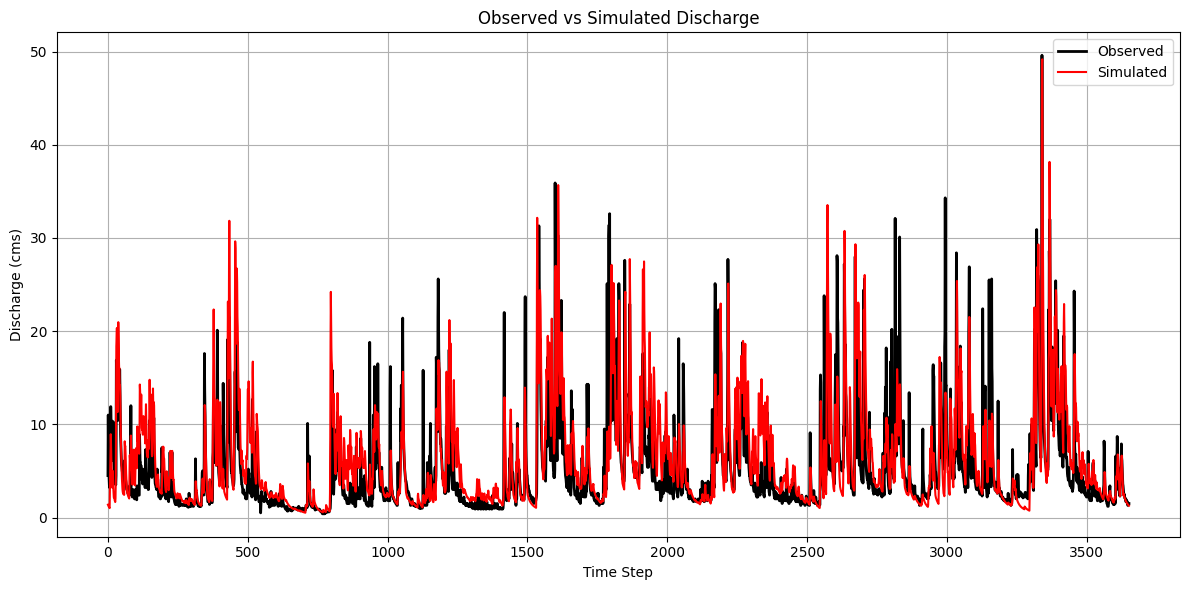

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(q_obs, label="Observed", color='black', linewidth=2)
plt.plot(qsmoothed, label="Simulated", color='red', linestyle="-")
plt.title("Observed vs Simulated Discharge")
plt.xlabel("Time Step")
plt.ylabel("Discharge (cms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("HBV_TimeSeriesPlot.png")
plt.show()

In [ ]:
df_ts = pd.DataFrame({
    "TimeStep": np.arange(1, n + 1),
    "Observed": q_obs,
    "Simulated": qsmoothed
})
df_ts.to_excel("HBV_Simulation_TimeSeries.xlsx", index=False)

# **8.1. Forward Uncertainty Analysis - FOSM method**

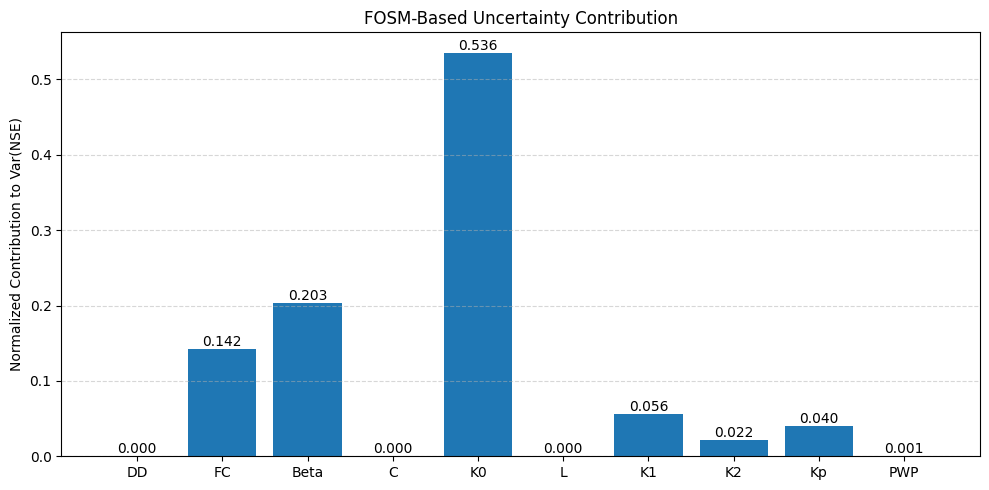

In [ ]:
param_names = ["DD", "FC", "Beta", "C", "K0", "L", "K1", "K2", "Kp", "PWP"]
params_mean = np.mean(params_sampled, axis=0)
params_std = np.std(params_sampled, axis=0)
delta = 1e-4
cflux_coeff = 0.01


def compute_nse(params):
    d, fc, beta, c, k0, l, k1, k2, kp, pwp = params
    snow, soil, s1, s2 = init_snow, init_soil, init_s1, init_s2
    qsim = []
    for i in range(len(temp)):
        T = temp[i]
        P = prec[i]
        ep = (1 + c * (T - dpem[month[i]])) * dpem[month[i]]

        if T < tt:
            snow += P
            lwater = 0
        else:
            melt = d * (T - tt)
            melt = min(melt, snow)
            snow = max(snow - melt, 0)
            lwater = P + melt

        ea = ep if soil > pwp else ep * (soil / pwp)
        dq = lwater * (soil / fc) ** beta if soil > 0 else 0
        soil += lwater - dq - ea


        soil_deficit = max(fc - soil, 0)
        cflux = min(cflux_coeff * soil_deficit, s1)
        soil += cflux
        s1 -= cflux

        q0 = max(0, s1 - l) * k0
        s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
        s2 = s2 + s1 * kp - s2 * k2
        q = q0 + s1 * k1 + s2 * k2
        qcms = (q * area * 1000) / (24 * 3600)
        qsim.append(qcms)

    qsim = np.array(qsim)
    err = q_obs - qsim
    return 1 - np.sum(err ** 2) / np.sum((q_obs - np.mean(q_obs)) ** 2)


var_y = 0
partials = []
contributions = []

for i, name in enumerate(param_names):
    p_base = params_mean.copy()
    p_plus = p_base.copy()
    p_minus = p_base.copy()
    p_plus[i] += delta
    p_minus[i] -= delta

    f_plus = compute_nse(p_plus)
    f_minus = compute_nse(p_minus)

    df_dx = (f_plus - f_minus) / (2 * delta)
    var_i = params_std[i] ** 2
    contrib = (df_dx ** 2) * var_i

    partials.append(df_dx)
    contributions.append(contrib)
    var_y += contrib


contributions = np.array(contributions)
sensitivity_ratio = contributions / var_y


df_fosm = pd.DataFrame({
    "Parameter": param_names,
    "Derivative": partials,
    "Variance": params_std ** 2,
    "Contribution_to_OutputVar": contributions,
    "Normalized_Contribution": sensitivity_ratio
})
df_fosm.to_excel("HBV_FOSM_Sensitivity.xlsx", index=False)


plt.figure(figsize=(10, 5))
bars = plt.bar(param_names, sensitivity_ratio)
plt.ylabel("Normalized Contribution to Var(NSE)")
plt.title("FOSM-Based Uncertainty Contribution (with CFLUX only)")
for bar, val in zip(bars, sensitivity_ratio):
    plt.text(bar.get_x() + bar.get_width()/2, val, f"{val:.3f}", ha='center', va='bottom')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# **8.2. Forward Uncertainty Analysis - MonteCarlo method**

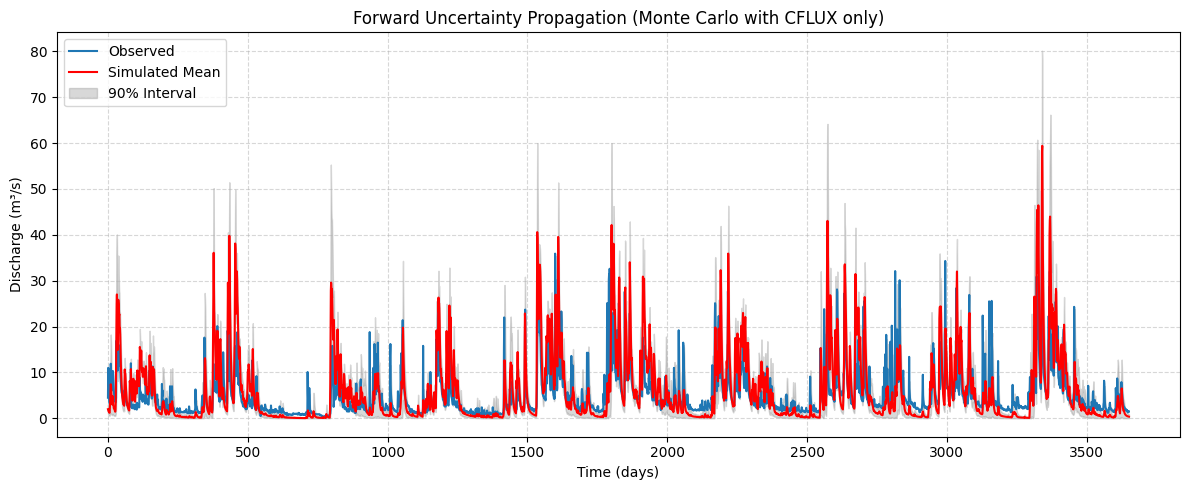

Percent coverage of observed discharges: 47.62%


In [ ]:
n_sim = 2000
n = len(temp)
aq = np.mean(q_obs)
cflux_coeff = 0.01

params_mc = np.random.uniform(low=lower, high=upper, size=(n_sim, len(lower)))
qsim_ensemble = []
nse_ensemble = []


def run_hbv(params):
    d, fc, beta, c, k0, l, k1, k2, kp, pwp = params
    snow, soil, s1, s2 = init_snow, init_soil, init_s1, init_s2
    qsim = []

    for i in range(n):
        T = temp[i]
        P = prec[i]
        ep = (1 + c * (T - dpem[month[i]])) * dpem[month[i]]

        if T < tt:
            snow += P
            lwater = 0
        else:
            melt = d * (T - tt)
            melt = min(melt, snow)
            snow = max(snow - melt, 0)
            lwater = P + melt

        ea = ep if soil > pwp else ep * (soil / pwp)
        dq = lwater * (soil / fc) ** beta if soil > 0 else 0
        soil += lwater - dq - ea


        soil_deficit = max(fc - soil, 0)
        cflux = min(cflux_coeff * soil_deficit, s1)
        soil += cflux
        s1 -= cflux

        q0 = max(0, s1 - l) * k0
        s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
        s2 = s2 + s1 * kp - s2 * k2
        q = q0 + s1 * k1 + s2 * k2
        qcms = (q * area * 1000) / (24 * 3600)
        qsim.append(qcms)

    return np.array(qsim)


for s in range(n_sim):
    qsim = run_hbv(params_mc[s])
    nse = 1 - np.sum((q_obs - qsim) ** 2) / np.sum((q_obs - aq) ** 2)
    qsim_ensemble.append(qsim)
    nse_ensemble.append(nse)

qsim_ensemble = np.array(qsim_ensemble)


qmean = np.mean(qsim_ensemble, axis=0)
q5 = np.percentile(qsim_ensemble, 5, axis=0)
q95 = np.percentile(qsim_ensemble, 95, axis=0)


df_uncertainty = pd.DataFrame({
    "Observed": q_obs,
    "Mean_Simulated": qmean,
    "P05": q5,
    "P95": q95
})
df_uncertainty.to_excel("HBV_Uncertainty_MonteCarlo.xlsx", index=False)


plt.figure(figsize=(12, 5))
plt.plot(q_obs, label="Observed", linewidth=1.5)
plt.plot(qmean, label="Simulated Mean", color='red', linewidth=1.5)
plt.fill_between(range(n), q5, q95, color='gray', alpha=0.3, label="90% Interval")
plt.title("Forward Uncertainty Propagation (Monte Carlo with CFLUX only)")
plt.xlabel("Time (days)")
plt.ylabel("Discharge (m³/s)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


within_band = (q_obs >= q5) & (q_obs <= q95)
coverage_ratio = np.sum(within_band) / len(q_obs) * 100
print(f"Percent coverage of observed discharges: {coverage_ratio:.2f}%")


# **9.1. Backward Uncertainty Analysis - GLUE method**

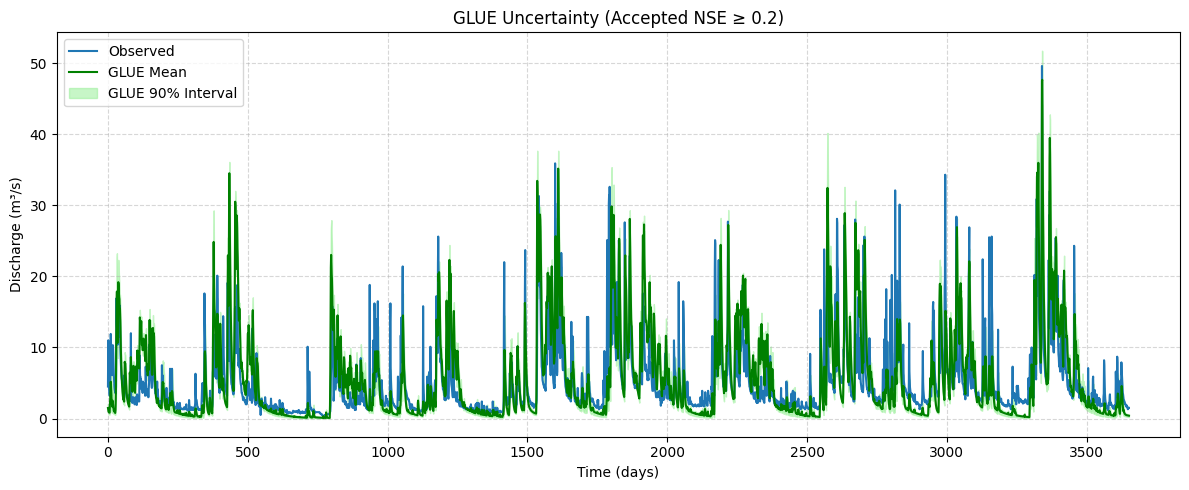

Percent coverage of observed discharges: 21.44%


In [ ]:
threshold_nse = 0.2
n = len(temp)
aq = np.mean(q_obs)
cflux_coeff = 0.01


q_ensemble = []
nse_list = []

def run_model(params):
    d, fc, beta, c, k0, l, k1, k2, kp, pwp = params
    snow, soil, s1, s2 = init_snow, init_soil, init_s1, init_s2
    qsim = []

    for i in range(n):
        T = temp[i]
        P = prec[i]
        ep = (1 + c * (T - dpem[month[i]])) * dpem[month[i]]

        if T < tt:
            snow += P
            lwater = 0
        else:
            melt = d * (T - tt)
            melt = min(melt, snow)
            snow = max(snow - melt, 0)
            lwater = P + melt

        ea = ep if soil > pwp else ep * (soil / pwp)
        dq = lwater * (soil / fc) ** beta if soil > 0 else 0
        soil += lwater - dq - ea

        soil_deficit = max(fc - soil, 0)
        cflux = min(cflux_coeff * soil_deficit, s1)
        soil += cflux
        s1 -= cflux

        q0 = max(0, s1 - l) * k0
        s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
        s2 = s2 + s1 * kp - s2 * k2
        q = q0 + s1 * k1 + s2 * k2
        qcms = (q * area * 1000) / (24 * 3600)
        qsim.append(qcms)

    return np.array(qsim)

for i in range(len(params_sampled)):
    qsim = run_model(params_sampled[i])
    nse = 1 - np.sum((q_obs - qsim) ** 2) / np.sum((q_obs - aq) ** 2)
    q_ensemble.append(qsim)
    nse_list.append(nse)

q_ensemble = np.array(q_ensemble)
nse_list = np.array(nse_list)


accepted_idx = np.where(nse_list >= threshold_nse)[0]
accepted_q = q_ensemble[accepted_idx]


q_mean = np.mean(accepted_q, axis=0)
q_5 = np.percentile(accepted_q, 5, axis=0)
q_95 = np.percentile(accepted_q, 95, axis=0)


df_glue_uncertainty = pd.DataFrame({
    "Observed_Q": q_obs,
    "Simulated_Mean": q_mean,
    "Q_5th_Percentile": q_5,
    "Q_95th_Percentile": q_95
})
df_glue_uncertainty.to_excel("HBV_GLUE_Uncertainty.xlsx", index=False)


plt.figure(figsize=(12, 5))
plt.plot(q_obs, label="Observed", linewidth=1.5)
plt.plot(q_mean, label="GLUE Mean", color='green', linewidth=1.5)
plt.fill_between(range(n), q_5, q_95, color='lightgreen', alpha=0.5, label="GLUE 90% Interval")
plt.title(f"GLUE Uncertainty (Accepted NSE ≥ {threshold_nse})")
plt.xlabel("Time (days)")
plt.ylabel("Discharge (m³/s)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


within_band = (q_obs >= q_5) & (q_obs <= q_95)
coverage_ratio = np.sum(within_band) / len(q_obs) * 100
print(f"Percent coverage of observed discharges: {coverage_ratio:.2f}%")


# **10. Calibration Process (differential_evolution)**

In [ ]:
from scipy.optimize import differential_evolution


def hbv_nse_objective(params, temp, prec, ep, q_obs, area, tt, n):
    try:
        d, fc, beta, c, k0, l, k1, k2, kp, pwp = params
        snow, soil, s1, s2 = 0, 0.5 * fc, 0.0, 0.0
        qsim = []

        for i in range(n):
            T, P = temp[i], prec[i]
            ep_i = (1 + c * (T - ep[month[i]])) * ep[month[i]]

            if T < tt:
                snow += P
                lwater = 0
            else:
                melt = d * (T - tt)
                melt = min(melt, snow)
                snow = max(snow - melt, 0)
                lwater = P + melt

            ea = ep_i if soil > pwp else ep_i * (soil / pwp)
            dq = lwater * (soil / fc) ** beta if soil > 0 else 0
            soil += lwater - dq - ea

            q0 = max(0, s1 - l) * k0
            s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
            s2 = s2 + s1 * kp - s2 * k2
            q = q0 + s1 * k1 + s2 * k2
            qcms = (q * area * 1000) / (24 * 3600)
            qsim.append(qcms)

        qsim = np.array(qsim)
        if np.any(np.isnan(qsim)) or np.sum(qsim) == 0:
            return 1e6  # penalize failure
        nse = 1 - np.sum((q_obs - qsim) ** 2) / np.sum((q_obs - np.mean(q_obs)) ** 2)
        return -nse
    except:
        return 1e6


bounds = list(zip(bounds_data["lb"].values, bounds_data["ub"].values))

result = differential_evolution(
    hbv_nse_objective,
    bounds,
    args=(temp, prec, dpem, q_obs, area, tt, len(q_obs)),
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=1e-6,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=42,
    polish=True,
    disp=True
)


best_calibrated_params = result.x
best_calibrated_nse = -result.fun

print("Calibration has finished....!")
print(f"Optimized NSE is {best_calibrated_nse:.4f}")
print("Calibrated Parameters:")
for name, val in zip(["DD", "FC", "Beta", "C", "K0", "L", "K1", "K2", "Kp", "PWP"], best_calibrated_params):
    print(f"{name}: {val:.4f}")


differential_evolution step 1: f(x)= -0.4217286528583106
differential_evolution step 2: f(x)= -0.4584217694608733
differential_evolution step 3: f(x)= -0.4584217694608733
differential_evolution step 4: f(x)= -0.4750065855775236
differential_evolution step 5: f(x)= -0.48394876018995714
differential_evolution step 6: f(x)= -0.48394876018995714
differential_evolution step 7: f(x)= -0.48394876018995714
differential_evolution step 8: f(x)= -0.48429862502350673
differential_evolution step 9: f(x)= -0.49299047005496166
differential_evolution step 10: f(x)= -0.49913659732717164
differential_evolution step 11: f(x)= -0.49913659732717164
differential_evolution step 12: f(x)= -0.5099224207391253
differential_evolution step 13: f(x)= -0.5099224207391253
differential_evolution step 14: f(x)= -0.5099224207391253
differential_evolution step 15: f(x)= -0.5150880716035712
differential_evolution step 16: f(x)= -0.5150880716035712
differential_evolution step 17: f(x)= -0.5150880716035712
differential_evo

# **11. One-at-a-Time (OAT) Sensitivity Analysis**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import qmc


steps = 200
param_names = ["DD", "FC", "Beta", "C", "K0", "L", "K1", "K2", "Kp", "PWP"]
n_params = len(param_names)
n = len(temp)
aq = np.mean(q_obs)
cflux_coeff = 0.01

results = []

for i, pname in enumerate(param_names):

    sampler = qmc.LatinHypercube(d=1)
    lhs_sample = sampler.random(n=steps)
    step_values = qmc.scale(lhs_sample, lower[i:i+1], upper[i:i+1]).flatten()

    for val in step_values:
        params = np.mean(params_sampled, axis=0).copy()
        params[i] = val

        d, fc, beta, c, k0, l, k1, k2, kp, pwp = params
        snow, soil, s1, s2 = init_snow, init_soil, init_s1, init_s2
        qsim = []

        for j in range(n):
            T = temp[j]
            P = prec[j]
            ep = (1 + c * (T - dpem[month[j]])) * dpem[month[j]]

            if T < tt:
                snow += P
                lwater = 0
            else:
                melt = d * (T - tt)
                melt = min(melt, snow)
                snow = max(snow - melt, 0)
                lwater = P + melt

            ea = ep if soil > pwp else ep * (soil / pwp)
            dq = lwater * (soil / fc) ** beta if soil > 0 else 0
            soil += lwater - dq - ea

            soil_deficit = max(fc - soil, 0)
            cflux = min(cflux_coeff * soil_deficit, s1)
            soil += cflux
            s1 -= cflux

            q0 = max(0, s1 - l) * k0
            s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
            s2 = s2 + s1 * kp - s2 * k2
            q = q0 + s1 * k1 + s2 * k2
            qcms = (q * area * 1000) / (24 * 3600)
            qsim.append(qcms)

        qsim = np.array(qsim)
        err = q_obs - qsim
        nse = 1 - np.sum(err**2) / np.sum((q_obs - aq) ** 2)
        rmse = np.sqrt(mean_squared_error(q_obs, qsim))
        r2 = r2_score(q_obs, qsim)

        results.append({
            "Parameter": pname,
            "Value": val,
            "NSE": nse,
            "RMSE": rmse,
            "R2": r2
        })


df_oat = pd.DataFrame(results)
df_oat.to_excel("HBV_OAT_Sensitivity.xlsx", index=False)


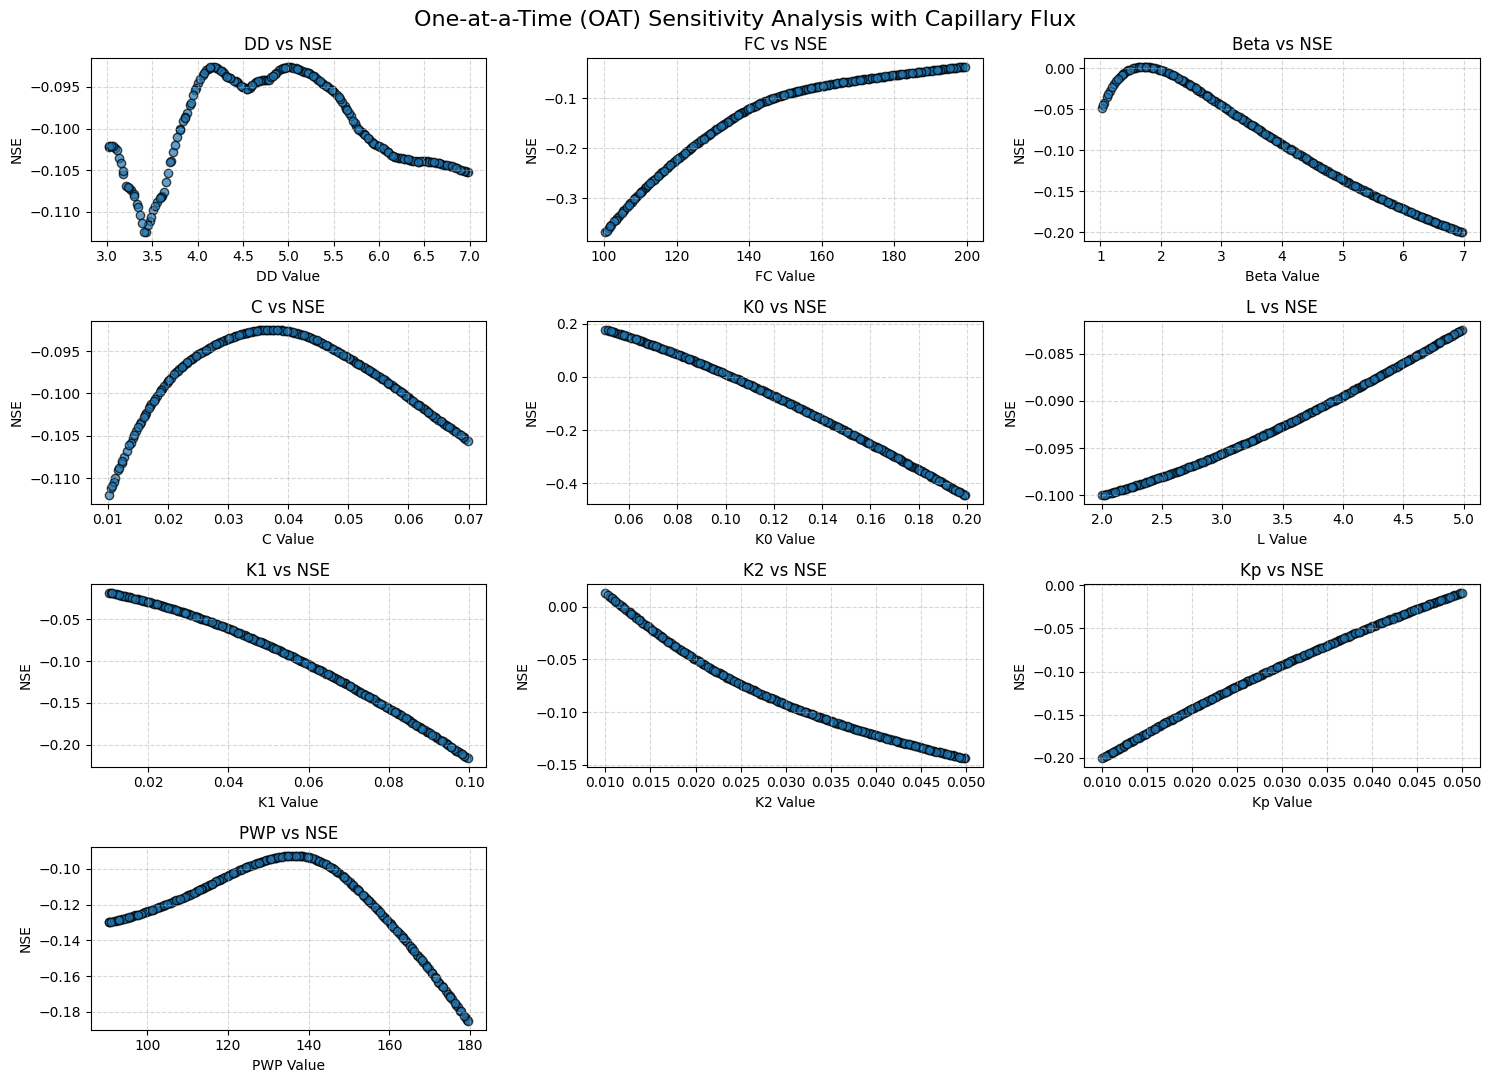

In [ ]:
import matplotlib.pyplot as plt


unique_params = df_oat["Parameter"].unique()
n_params = len(unique_params)


plt.figure(figsize=(15, 2.5 * n_params // 3 + 3))

for i, param in enumerate(unique_params):
    plt.subplot((n_params + 2) // 3, 3, i + 1)
    subset = df_oat[df_oat["Parameter"] == param]
    plt.scatter(subset["Value"], subset["NSE"], alpha=0.7, edgecolors='k')
    plt.title(f"{param} vs NSE")
    plt.xlabel(f"{param} Value")
    plt.ylabel("NSE")
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("One-at-a-Time (OAT) Sensitivity Analysis with Capillary Flux", fontsize=16)
plt.show()


# **12. HBV Sobol Sensitivity Analysis**

In [ ]:
! pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 10.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol


param_names = ["DD", "FC", "Beta", "C", "K0", "L", "K1", "K2", "Kp", "PWP"]
lower = np.array([1, 50, 0.1, 0.01, 0.01, 1, 0.01, 0.01, 0.01, 10])
upper = np.array([10, 400, 5, 1.0, 1.0, 50, 1.0, 1.0, 1.0, 500])
problem = {
    'num_vars': len(param_names),
    'names': param_names,
    'bounds': list(zip(lower, upper))
}


n_samples = 64
param_values = saltelli.sample(problem, n_samples, calc_second_order=True)


aq = np.mean(q_obs)
n = len(temp)
cflux_coeff = 0.01


def run_model(params):
    d, fc, beta, c, k0, l, k1, k2, kp, pwp = params
    snow, soil, s1, s2 = init_snow, init_soil, init_s1, init_s2
    qsim = []
    for i in range(n):
        T = temp[i]
        P = prec[i]
        ep = (1 + c * (T - dpem[month[i]])) * dpem[month[i]]
        if T < tt:
            snow += P
            lwater = 0
        else:
            melt = d * (T - tt)
            melt = min(melt, snow)
            snow -= melt
            lwater = P + melt
        ea = ep if soil > pwp else ep * (soil / pwp)
        dq = lwater * (soil / fc) ** beta if soil > 0 else 0
        soil += lwater - dq - ea
        soil_deficit = max(fc - soil, 0)
        cflux = min(cflux_coeff * soil_deficit, s1)
        soil += cflux
        s1 -= cflux
        q0 = max(0, s1 - l) * k0
        s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
        s2 = s2 + s1 * kp - s2 * k2
        q = q0 + s1 * k1 + s2 * k2
        qcms = (q * area * 1000) / (24 * 3600)
        qsim.append(qcms)
    return np.array(qsim)


Y = []
for p in param_values:
    qsim = run_model(p)
    nse = 1 - np.sum((q_obs - qsim) ** 2) / np.sum((q_obs - aq) ** 2)
    Y.append(nse)


Si = sobol.analyze(problem, np.array(Y), calc_second_order=True, print_to_console=False)


df_sobol = pd.DataFrame({
    'Parameter': param_names,
    'S1': Si['S1'],
    'S1_conf': Si['S1_conf'],
    'ST': Si['ST'],
    'ST_conf': Si['ST_conf']
})
df_sobol.to_excel("HBV_Sobol_Sensitivity.xlsx", index=False)


s2_matrix = pd.DataFrame(np.nan, index=param_names, columns=param_names)
s2_conf_matrix = pd.DataFrame(np.nan, index=param_names, columns=param_names)

k = len(param_names)
for i in range(k):
    for j in range(i + 1, k):
        s2_matrix.iloc[i, j] = Si['S2'][i, j]
        s2_conf_matrix.iloc[i, j] = Si['S2_conf'][i, j]


with pd.ExcelWriter("HBV_Sobol_Interactions.xlsx") as writer:
    s2_matrix.to_excel(writer, sheet_name="S2 (Interaction)")
    s2_conf_matrix.to_excel(writer, sheet_name="S2_conf")

print("The excel file (SOBOL) has been saved...!")


/tmp/ipython-input-38-1373533914.py:18: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, n_samples, calc_second_order=True)


تحلیل حساسیت Sobol همراه با اثرات متقابل (S2) ذخیره شد.


/usr/local/lib/python3.11/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


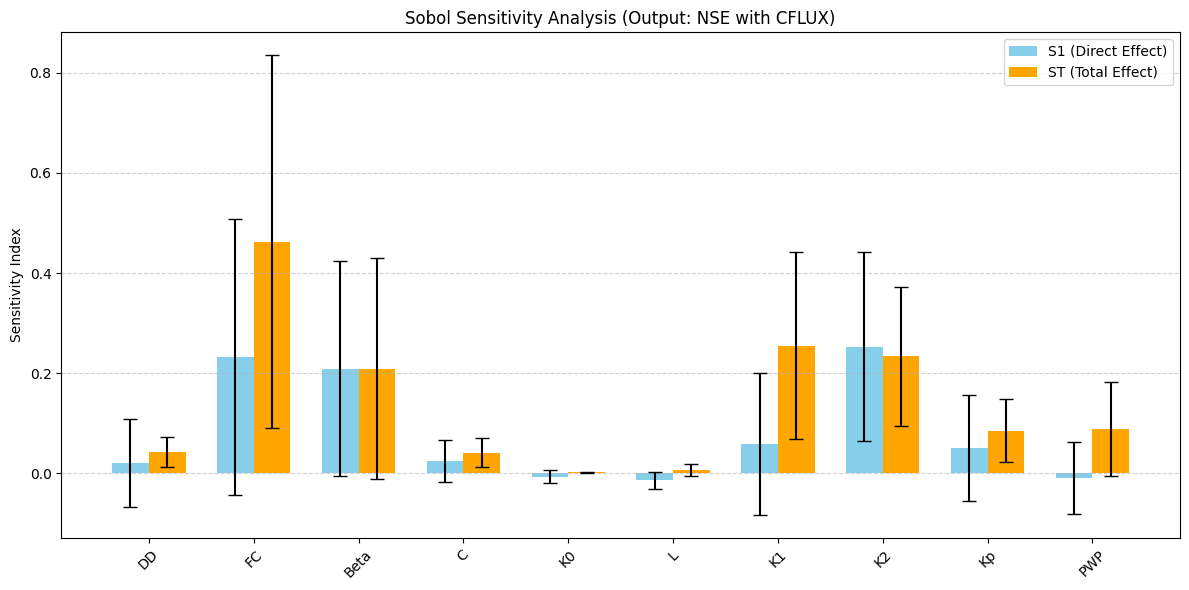

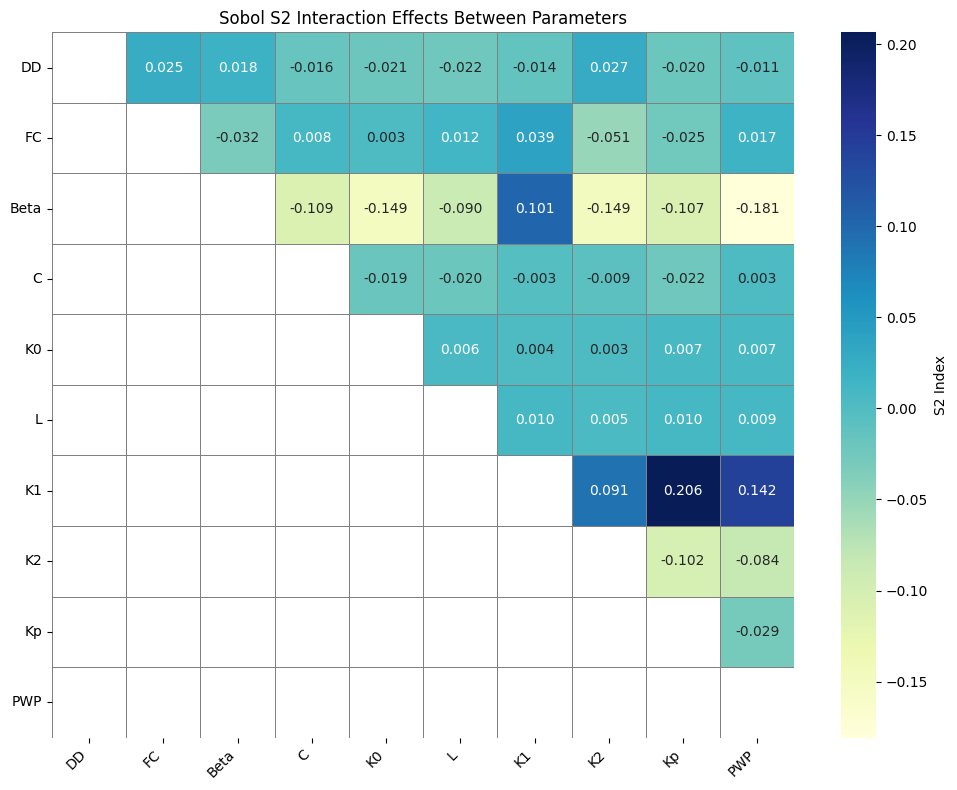

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df_sobol = pd.read_excel("HBV_Sobol_Sensitivity.xlsx")


param_names = df_sobol["Parameter"].values
S1 = df_sobol["S1"].values
S1_conf = df_sobol["S1_conf"].values
ST = df_sobol["ST"].values
ST_conf = df_sobol["ST_conf"].values


x = np.arange(len(param_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, S1, width, yerr=S1_conf, capsize=5, label='S1 (Direct Effect)', color='skyblue')
plt.bar(x + width/2, ST, width, yerr=ST_conf, capsize=5, label='ST (Total Effect)', color='orange')

plt.xticks(x, param_names, rotation=45)
plt.ylabel("Sensitivity Index")
plt.title("Sobol Sensitivity Analysis (Output: NSE with CFLUX)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

import seaborn as sns


s2_masked = s2_matrix.copy()
for i in range(len(param_names)):
    for j in range(i):
        s2_masked.iloc[i, j] = np.nan


plt.figure(figsize=(10, 8))
sns.heatmap(s2_masked, annot=True, fmt=".3f", cmap="YlGnBu", mask=s2_masked.isnull(),
            cbar_kws={"label": "S2 Index"}, linewidths=0.5, linecolor='gray')
plt.title("Sobol S2 Interaction Effects Between Parameters")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



**--Full simple code without Soil Flux**

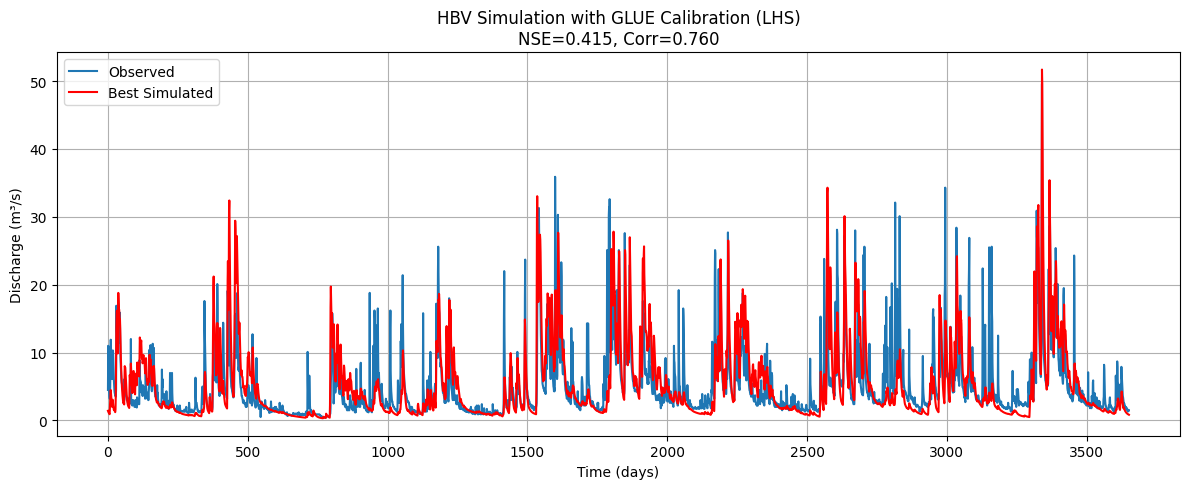

In [ ]:
# === HBV Hydrologic Model with GLUE-Based Calibration (LHS version) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Load input data from Excel file
excel_data = pd.read_excel("HBVinputs.xlsx", sheet_name=None)
df_input = excel_data["InputPrecipTemp"]
df_qobs = excel_data["Qobs"]
df_evap = excel_data["MonthlyTempEvap"]
df_bounds = excel_data["Bounds"]
df_iv = excel_data["IV"].set_index("name")["val"]

# Extract inputs
prec = df_input["Precipitation"].values
temp = df_input["Temperature"].values
month = df_input["Month"].values.astype(int) - 1
q_obs = df_qobs["Qobs"].values
dpem = df_evap["dpem"].values

# Model settings
n = len(temp)
area = df_iv["WatershedArea"]
tt = df_iv["T_t"]
ns = int(df_iv["NumberOfSimulation"])
init_snow = df_iv["SnowMeltThr"]
init_soil = df_iv["SoilMoisture"]
init_s1 = df_iv["S_1"]
init_s2 = df_iv["S_2"]
opt_criterion = int(df_iv.get("OptimizationCriteria", 2))

# Bounds
lower = df_bounds["lb"].values
upper = df_bounds["ub"].values

# Latin Hypercube Sampling
sampler = qmc.LatinHypercube(d=len(lower))
sample = sampler.random(n=ns)
param_samples = qmc.scale(sample, lower, upper)

# Run GLUE ensemble
q_ensembles = []
nse_list = []
rmse_list = []
corr_list = []
tbias_list = []
mq_list = []

for s in range(ns):
    d, fc, beta, c, k0, l, k1, k2, kp, pwp = param_samples[s]
    snow = init_snow
    soil = init_soil
    s1 = init_s1
    s2 = init_s2
    qsim = []
    for i in range(n):
        T = temp[i]
        P = prec[i]
        ep = (1 + c * (T - dpem[month[i]])) * dpem[month[i]]

        if T < tt:
            snow += P
            lwater = 0
        else:
            melt = d * (T - tt)
            melt = min(melt, snow)
            snow = max(snow - melt, 0)
            lwater = P + melt

        ea = ep if soil > pwp else ep * (soil / pwp)
        dq = lwater * (soil / fc) ** beta if soil > 0 else 0
        soil += lwater - dq - ea

        q0 = max(0, s1 - l) * k0
        s1 = s1 + dq - q0 - s1 * k1 - s1 * kp
        s2 = s2 + s1 * kp - s2 * k2
        q = q0 + s1 * k1 + s2 * k2
        qcms = (q * area * 1000) / (24 * 3600)
        qsim.append(qcms)

    qsim = np.array(qsim)
    q_ensembles.append(qsim)
    err = q_obs - qsim
    nse = 1 - np.sum(err**2) / np.sum((q_obs - np.mean(q_obs))**2)
    rmse = np.sqrt(np.mean(err**2))
    corr = np.corrcoef(q_obs, qsim)[0, 1]
    tbias = np.sum(qsim) / np.sum(q_obs)

    nse_list.append(nse)
    rmse_list.append(rmse)
    corr_list.append(corr)
    tbias_list.append(tbias)
    mq_list.append(np.sum(qsim))

# Select best based on criterion
if opt_criterion == 1:
    best_idx = np.argmin(rmse_list)
elif opt_criterion == 2:
    best_idx = np.argmax(nse_list)
elif opt_criterion == 3:
    best_idx = np.argmax(corr_list)
elif opt_criterion == 4:
    best_idx = np.argmin(1 - np.square(tbias_list))
else:
    best_idx = np.argmax(nse_list)

# Best simulation
best_params = param_samples[best_idx]
best_qsim = q_ensembles[best_idx]

# Evaluation
best_nse = nse_list[best_idx]
best_corr = corr_list[best_idx]

# Save results
df_result = pd.DataFrame({"Observed_Q": q_obs, "Simulated_Q": best_qsim})
df_params = pd.DataFrame({"Parameter": ["DD", "FC", "Beta", "C", "K0", "L", "K1", "K2", "Kp", "PWP"], "Value": best_params})
df_eval = pd.DataFrame({"Metric": ["NSE", "Correlation"], "Value": [best_nse, best_corr]})

with pd.ExcelWriter("HBV_GLUE.xlsx") as writer:
    df_result.to_excel(writer, sheet_name="Qsim_vs_Qobs", index=False)
    df_params.to_excel(writer, sheet_name="Best_Parameters", index=False)
    df_eval.to_excel(writer, sheet_name="Evaluation", index=False)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(q_obs, label="Observed")
plt.plot(best_qsim, label="Best Simulated", color='red')
plt.title(f"HBV Simulation \nNSE={best_nse:.3f}, Corr={best_corr:.3f}")
plt.xlabel("Time (days)")
plt.ylabel("Discharge (m3/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**--A simple example of two imporatant sampling methods**

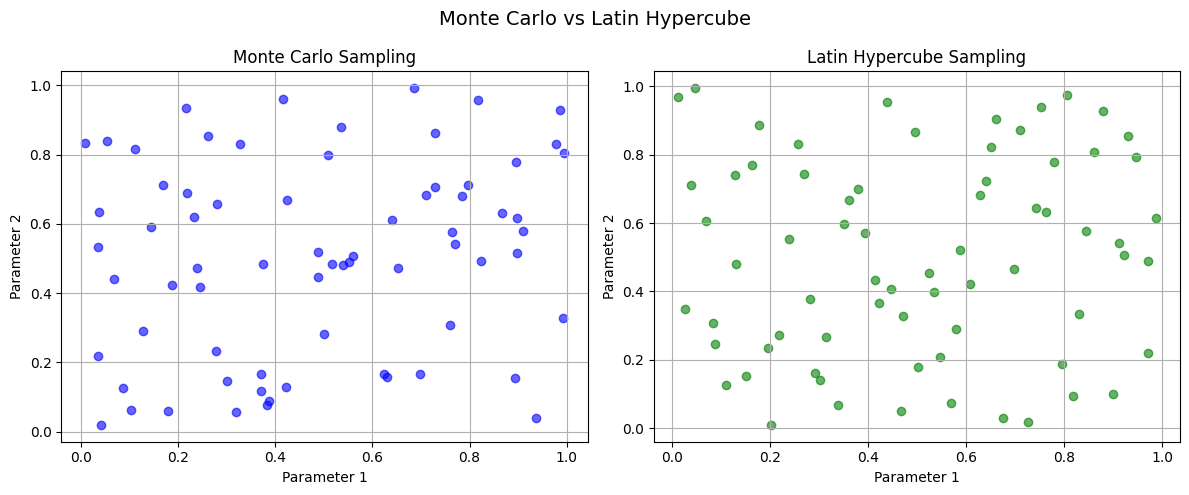

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc


ns = 70
param_bounds = [(0, 1), (0, 1)]

# --- Monte Carlo ---
mc_samples = np.random.uniform(0, 1, size=(ns, 2))

# --- Latin Hypercube Sampling ---
lhs_sampler = qmc.LatinHypercube(d=2)
lhs_unit = lhs_sampler.random(n=ns)
lhs_samples = qmc.scale(lhs_unit, [b[0] for b in param_bounds], [b[1] for b in param_bounds])


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(mc_samples[:, 0], mc_samples[:, 1], color='blue', alpha=0.6)
plt.title("Monte Carlo Sampling")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(lhs_samples[:, 0], lhs_samples[:, 1], color='green', alpha=0.6)
plt.title("Latin Hypercube Sampling")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.grid(True)

plt.suptitle("Monte Carlo vs Latin Hypercube", fontsize=14)
plt.tight_layout()
plt.show()
